# Random Forest - Bikeshare Rental Number Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from bayes_opt import BayesianOptimization
from time import time

In [2]:
# Import data 

df_bike_share = pd.read_csv('./data/bike_rentals_cleaned.txt')

df_bike_share.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [3]:
# creating flags
df_bike_share['is_sunday'] = df_bike_share['weekday'].apply(lambda x: 1 if x==0 else 0)
df_bike_share['is_saturday'] = df_bike_share['weekday'].apply(lambda x: 1 if x==6 else 0)
df_bike_share['is_friday'] = df_bike_share['weekday'].apply(lambda x: 1 if x==5 else 0)

df_bike_share['is_weekend'] = df_bike_share['weekday'].apply(lambda x: 1 if (x==0 or x==6) else 0)


df_bike_share.head()


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,is_sunday,is_saturday,is_friday,is_weekend
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985,0,1,0,1
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801,1,0,0,1
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349,0,0,0,0
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562,0,0,0,0
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600,0,0,0,0


In [4]:
def check_null_records(df):
    """
    Loop through all columns in dataset and check for null values
    """
    for col in df.columns:
        print(col, df[col].isnull().sum())


In [5]:
# Check for null values
check_null_records(df_bike_share)

instant 0
season 0
yr 0
mnth 0
holiday 0
weekday 0
workingday 0
weathersit 0
temp 0
atemp 0
hum 0
windspeed 0
cnt 0
is_sunday 0
is_saturday 0
is_friday 0
is_weekend 0


In [6]:
# Plot the median rentals for different categories of a column

def plot_rentals(df, col):
    plt.figure(figsize=(10,5))
    sns.barplot(data=df, x=col, y='cnt', estimator=np.median)
    plt.ylabel('Median rentals')
    plt.title(f'Median rentals for {col}')
    plt.show()

In [7]:
def plot_scatter(df, col):
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=df, x=col, y='cnt')
    plt.ylabel('No. of Rentals')
    plt.title(f'Scatter plot: No. of Rentals vs {col}')
    plt.show()

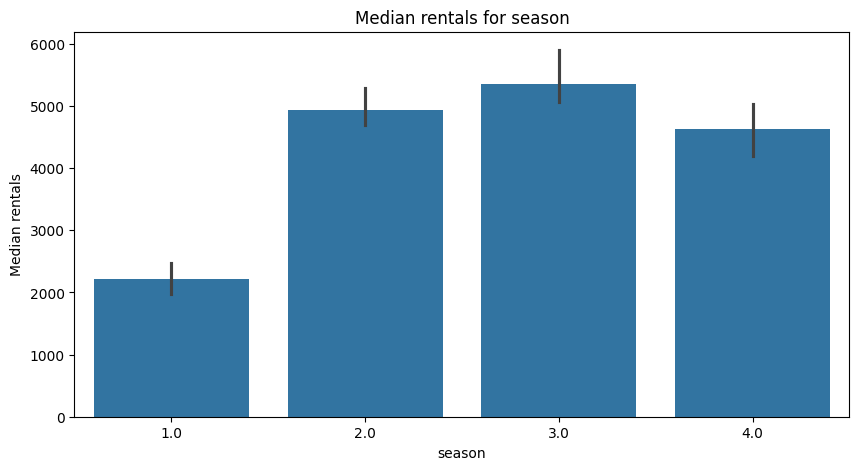

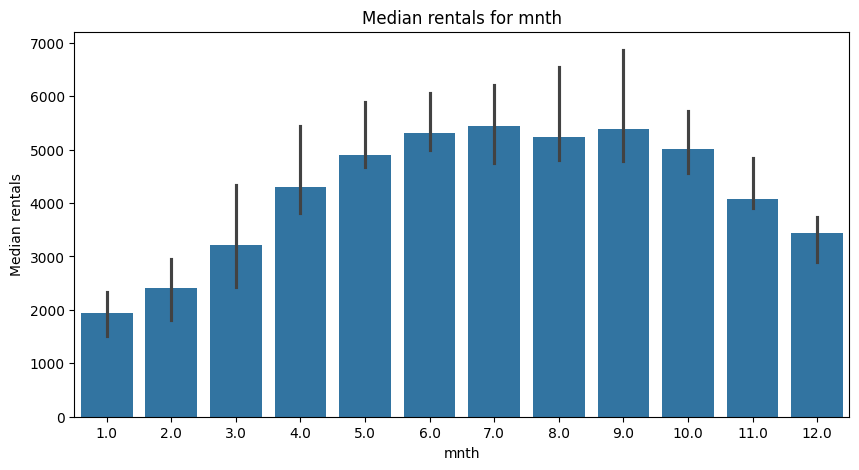

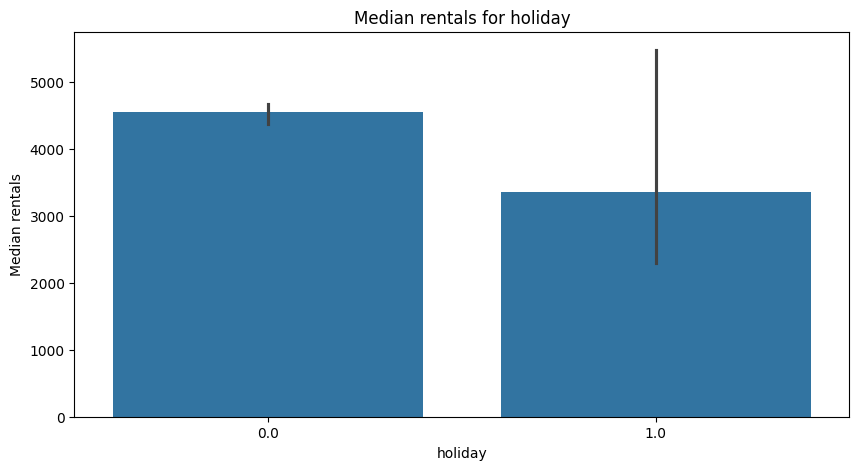

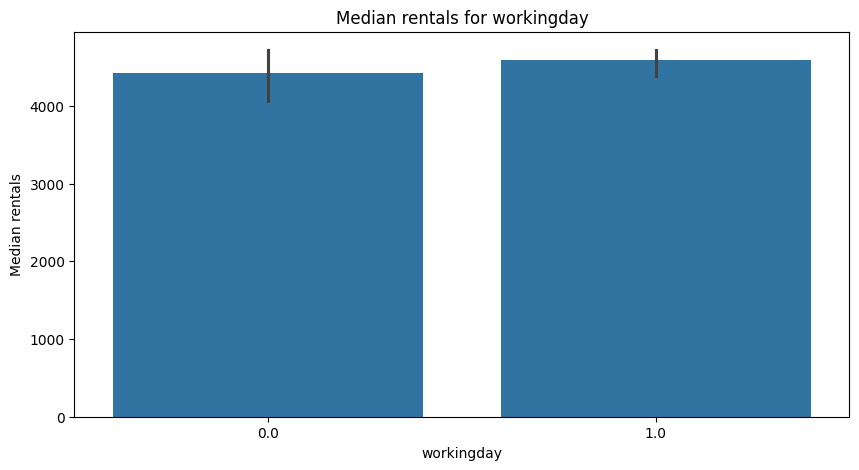

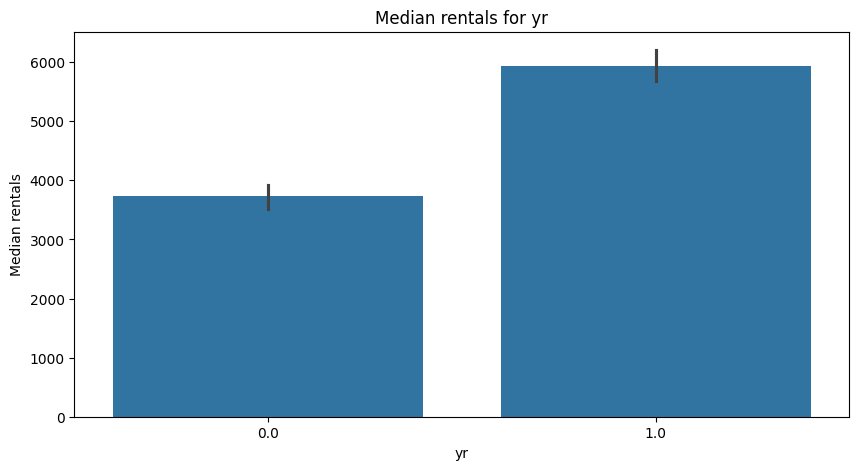

In [28]:
cols = ['season', 'mnth', 'holiday', 'workingday', 'yr']

for col in cols:
    plot_rentals(df_bike_share, col)

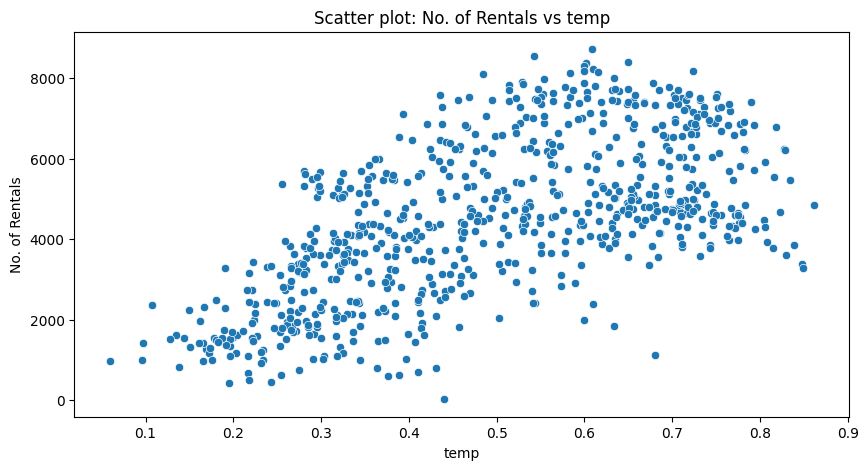

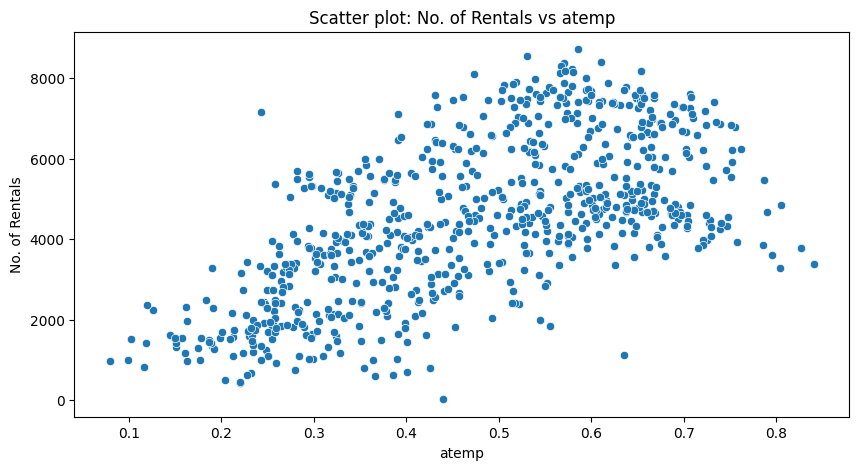

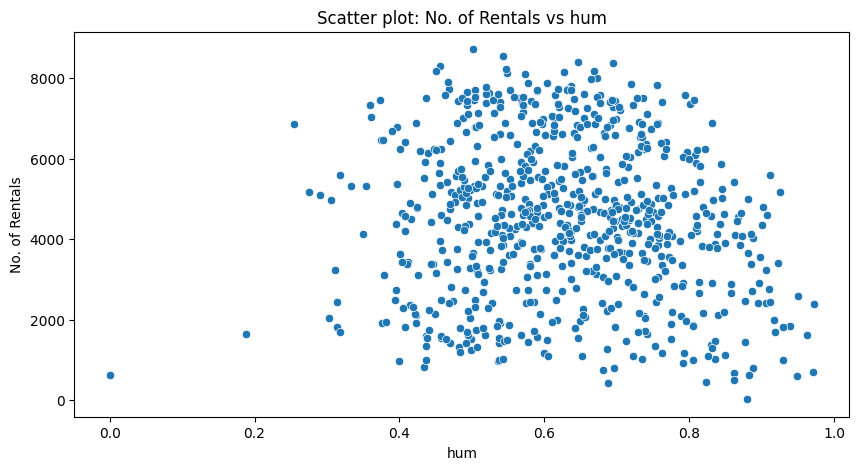

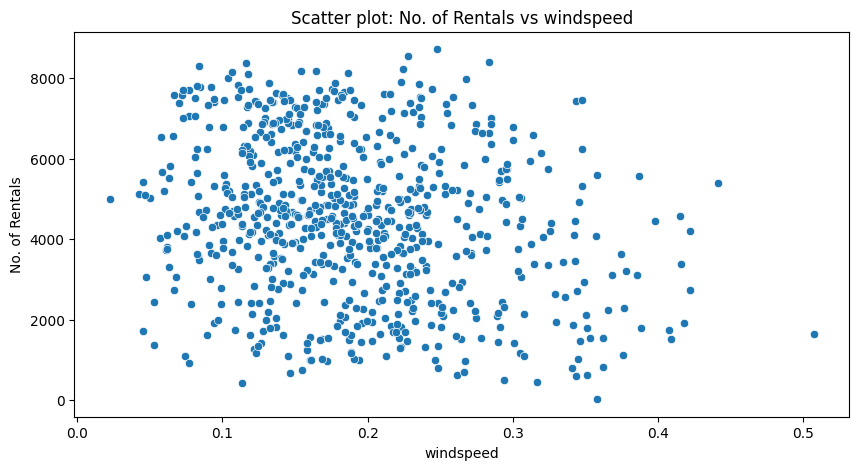

In [29]:
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']

for col in numerical_cols:
    plot_scatter(df_bike_share, col)

In [8]:
# Separating x and y columns

y_bikeshare = df_bike_share['cnt']
x_bikeshare = df_bike_share[[col for col in df_bike_share.columns if col != 'cnt' ]]

y_bikeshare.head()

0     985
1     801
2    1349
3    1562
4    1600
Name: cnt, dtype: int64

In [9]:
# Building model

rf_model = RandomForestRegressor(n_estimators=50, random_state=2, n_jobs=-1, warm_start=True)

# Fit model

cross_val_scores = cross_val_score(estimator=rf_model, X=x_bikeshare, y=y_bikeshare, scoring='neg_mean_squared_error' ,cv=10)



In [10]:
# Evaluation

rmse = np.sqrt(-cross_val_scores)

print(f'RMSE: {rmse.mean()}')

RMSE: 905.5943255413334


## Hyperparameter tuning

In [11]:
# Hyperparameters

n_estimators = [10, 20, 30, 50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8, 10]
max_features = ['auto', 0.8, 0.7, 0.6, 0.5, 0.4]
min_impurity_decrease = [0.0, 0.01, 0.05, 0.10, 0.15, 0.2]
min_samples_leaf = [1,2,4,6,8,10,20,30]
criterion = ['gini', 'entropy']

rf = RandomForestRegressor(random_state=2, n_jobs=-1, warm_start=True)

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_impurity_decrease': min_impurity_decrease,
    'min_samples_leaf': min_samples_leaf
}

X_train, X_test, y_train, y_test = train_test_split(x_bikeshare, y_bikeshare, test_size=0.2, random_state=42)

rcv_model = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=40)

rcv_model.fit(X_train, y_train)



/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
35 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _valida

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=2,
                                                   warm_start=True),
                   n_iter=40,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['auto', 0.8, 0.7, 0.6,
                                                         0.5, 0.4],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.05, 0.1,
                                                                  0.15, 0.2],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                                             20, 30],
                                        'n_estimators': [10, 20, 30, 50, 100,
                                                         150, 200, 500]},
                   scoring='neg_mean_squared_error')

In [12]:
# Best model

rcv_model.best_estimator_

rf_best_model = RandomForestRegressor(max_depth=8, max_features=0.5, min_impurity_decrease=0.05,
                      min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                      random_state=2, warm_start=True)

In [14]:

cross_val_scores = cross_val_score(estimator=rf_best_model, X=x_bikeshare, y=y_bikeshare, scoring='neg_mean_squared_error' ,cv=10)

rmse = np.sqrt(-cross_val_scores)

print(f'RMSE: {rmse.mean()}')

RMSE: 822.0317537144545


### Bayesian Optimization

In [82]:
def bayesian_objective(n_estimators, max_depth, max_features, min_impurity_decrease, min_samples_leaf):
    model = RandomForestRegressor(
                                    n_estimators=int(n_estimators),
                                    max_depth=int(max_depth),
                                    max_features=max_features,
                                    min_impurity_decrease=min_impurity_decrease,
                                    min_samples_leaf=int(min_samples_leaf),
                                    random_state=2
                                )
    

    return -1 * cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()

In [87]:
param_bound = {
    'n_estimators': (10, 500),
    'max_depth': (1,50),
    'max_features': (0.1,0.99),
    'min_impurity_decrease': (0.01, 0.2),
    'min_samples_leaf': (2,30)
}


optimizer = BayesianOptimization(f=bayesian_objective, pbounds=param_bound, random_state=2)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | max_depth | max_fe... | min_im... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 1.214e+06 | 22.36     | 0.1231    | 0.1144    | 14.19     | 216.0     |
| 2         | 6.167e+05 | 17.19     | 0.2821    | 0.1277    | 10.39     | 140.7     |
| 3         | 6.795e+05 | 31.44     | 0.5709    | 0.03557   | 16.38     | 100.4     |
| 4         | 7.874e+05 | 39.48     | 0.86      | 0.1039    | 25.7      | 49.03     |
| 5         | 7.117e+05 | 25.76     | 0.1581    | 0.09134   | 4.703     | 72.31     |
| 6         | 6.38e+05  | 24.35     | 0.6587    | 0.09843   | 13.02     | 214.6     |
| 7         | 1.476e+06 | 36.15     | 0.1129    | 0.1598    | 27.82     | 123.1     |
| 8         | 8.05e+05  | 22.23     | 0.2149    | 0.1286    | 18.14     | 406.4     |
| 9         | 7.949e+05 | 13.99     | 0.4704    | 0.05086   | 29.37     | 57.3      |
| 10        | 9.158e+05 | 15.54     | 0.1039    | 0.03

In [88]:
# The best parameters

best_params = optimizer.max['params']

best_params

{'max_depth': 36.154368651842184,
 'max_features': 0.11292307894771726,
 'min_impurity_decrease': 0.1598465190396028,
 'min_samples_leaf': 27.82117070233908,
 'n_estimators': 123.11041092295173}

In [89]:
# Training model with the best params from optimization

params_formatted = {
    'max_depth': int(best_params['max_depth']),
    'max_features': 0.11292307894771726,
    'min_impurity_decrease': 0.1598465190396028,
    'min_samples_leaf': int(best_params['min_samples_leaf']),
    'n_estimators': int(best_params['n_estimators'])
}


rf = RandomForestRegressor(**params_formatted, random_state=2, n_jobs=-1, warm_start=True)


cross_val_scores = cross_val_score(estimator=rf, X=x_bikeshare, y=y_bikeshare, scoring='neg_mean_squared_error' ,cv=10)

rmse = np.sqrt(-cross_val_scores)

print(f'RMSE: {rmse.mean()}')

RMSE: 1304.9543531314766
